# 🎯 Modelo de Marketing Mix (MMM)

**Objetivo**: Entrenar un modelo MMM usando el dataset limpio (sin multicolinealidad) para predecir transacciones y atribuir el efecto incremental de cada canal.

## Flujo del modelo:

1. **Feature Engineering**: Adstock, saturación (Hill), lags, estacionalidad
2. **Entrenamiento**: Ridge Regression con regularización
3. **Atribución**: Descomposición del efecto por canal (META vs GADS)
4. **Validación**: Métricas out-of-sample y gráficos

**Input**: `dataset_limpio_sin_multicolinealidad.csv` (del notebook 1)


## 1. Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.filters.filtertools import recursive_filter
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print("✓ Librerías cargadas")


✓ Librerías cargadas


In [2]:
# Cargar dataset limpio (output del notebook 1)
df_clean = pd.read_csv("dataset_limpio_sin_multicolinealidad.csv")

# Verificar que clicks_* fueron eliminados
clicks_cols = [c for c in df_clean.columns if 'clicks' in c.lower()]
if len(clicks_cols) > 0:
    print(f"⚠️ ADVERTENCIA: Aún hay {len(clicks_cols)} columnas con 'clicks': {clicks_cols}")
    print("   El dataset no fue limpiado correctamente.")
else:
    print("✅ Confirmado: Variables 'clicks_*' eliminadas")

print(f"\\nDataset cargado: {df_clean.shape}")
print(f"  Empresas: {df_clean['empresa'].nunique()}")
print(f"  Período: {df_clean['anio_iso'].min()}-{df_clean['anio_iso'].max()}")

# Cargar lista de features permitidas para el modelo
try:
    modelo_features = pd.read_csv("modelo_features.csv")
    ALLOWED_FEATURES = modelo_features["variable"].tolist()
    print(f"\n✓ Features permitidas cargadas: {len(ALLOWED_FEATURES)} variables")
except FileNotFoundError:
    print("\n⚠️ Advertencia: modelo_features.csv no encontrado. Usando todas las variables numéricas.")
    ALLOWED_FEATURES = None

# Variables prohibidas en el modelo (para optimización solamente)
FORBIDDEN_IN_MODEL = ["invest_META", "invest_GADS", "cpm_META", "cpm_GADS", "cpc_META", "cpc_GADS", "ctr_META", "ctr_GADS"]

# Verificar que no haya clicks_*
clicks_cols = [c for c in df_clean.columns if 'clicks' in c.lower() and c not in ['checkouts_GA']]
if len(clicks_cols) > 0:
    print(f"\n⚠️ ADVERTENCIA: Se encontraron columnas 'clicks': {clicks_cols}")
else:
    print("\n✅ VERIFICADO: No hay variables 'clicks' en el dataset")

# Verificar que las variables prohibidas estén en el dataset (para optimización) pero no se usen en modelo
forbidden_present = [v for v in FORBIDDEN_IN_MODEL if v in df_clean.columns]
if len(forbidden_present) > 0:
    print(f"\n🔧 Variables auxiliares presentes (OK, NO usar en modelo): {forbidden_present}")


✅ Confirmado: Variables 'clicks_*' eliminadas
\nDataset cargado: (2124, 43)
  Empresas: 22
  Período: 2023-2025

✓ Features permitidas cargadas: 32 variables

✅ VERIFICADO: No hay variables 'clicks' en el dataset

🔧 Variables auxiliares presentes (OK, NO usar en modelo): ['invest_META', 'invest_GADS', 'cpm_META', 'cpm_GADS']


## 2. Funciones de Transformación (Adstock + Hill)


In [3]:
def iso_week_monday(year_series, week_series):
    """Convierte año/semana ISO a fecha (lunes)"""
    y = pd.Series(year_series).astype(int).astype(str).str.zfill(4)
    w = pd.Series(week_series).astype(int).astype(str).str.zfill(2)
    return pd.to_datetime(y + w + "1", format="%G%V%u", errors="coerce")

def safe_zscore(s):
    """Z-score seguro (maneja std=0)"""
    s = pd.Series(s, dtype="float64")
    std = s.std()
    return (s - s.mean())/std if std and std != 0 else (s - s.mean())

def adstock(x, theta=0.6, init=0.0):
    """Efecto de memoria (carry-over)"""
    x = np.asarray(x, float)
    return recursive_filter(x, ar_coeff=[theta], init=init)

def hill(x, k=1.0, alpha=1.2):
    """Curva de saturación (diminishing returns)"""
    x = np.maximum(np.asarray(x, float), 0.0)
    return np.power(x, alpha) / (np.power(k, alpha) + np.power(x, alpha))

def media_response(series, theta=0.6, alpha=1.2, zscale=True):
    """Transformación completa: z-score + adstock + saturación"""
    x = np.asarray(series, float)
    if zscale:
        x = safe_zscore(pd.Series(x)).values
        x = x - x.min()  # Evita negativos
    a = adstock(x, theta=theta)
    k = np.median(a) or 1.0
    return hill(a, k=k, alpha=alpha)

print("✓ Funciones de transformación definidas")


✓ Funciones de transformación definidas


## 3. Feature Engineering

**Transformaciones aplicadas**:
1. **Medios** (impressions): Adstock (θ=0.70) + Saturación Hill (α=1.50)
2. ~~**Funnel** (sessions, add_to_carts, checkouts)~~: **ELIMINADAS** en notebook 1 (correcto)
3. **Estacionalidad**: sin/cos (52 semanas)
4. **Eventos**: Hot Sale, Cyber Monday, Black Friday, Navidad
5. **Variables Macro**: IPC, Índice de Confianza del Consumidor
6. **Efectos fijos**: Dummies por empresa

**Nota importante**: Las variables del funnel web fueron eliminadas intencionalmente para que los coeficientes de `impressions_META` e `impressions_GADS` capturen el efecto total (directo + indirecto) sobre transacciones.


In [4]:
# Configuración
TARGET = "transactions_GA"
ID_COLS = ["empresa", "anio_iso", "semana_iso", "Fecha", "periodo_m", "week_start"]
THETA_META, ALPHA_META = 0.30, 1.00
THETA_GADS, ALPHA_GADS = 0.30, 1.00
EVENTS = ["evt_Hot Sale", "evt_Cyber Monday", "evt_Black Friday", "evt_Navidad"]
FUNNEL = ["sessions_GA", "add_to_carts_GA", "checkouts_GA"]  # ⚠️ Eliminadas en notebook 1 (correcto)
MACROS = ["Variación IPC (%) General", "Índice de Confianza del Consumidor"]

# Preparar datos
df = df_clean.copy()

# Fecha
if "week_start" not in df.columns and "Fecha" not in df.columns:
    df["week_start"] = iso_week_monday(df["anio_iso"], df["semana_iso"])
    df = df.sort_values(["empresa", "week_start"]).set_index("week_start")
elif "Fecha" in df.columns:
    df["Fecha"] = pd.to_datetime(df["Fecha"])
    df = df.sort_values(["empresa", "Fecha"]).set_index("Fecha")
else:
    df = df.sort_values(["empresa", "week_start"]).set_index("week_start")

print(f"Dataset preparado: {df.shape}")
print(f"Índice: {df.index.min()} → {df.index.max()}")


Dataset preparado: (2124, 42)
Índice: 2023-10-02 00:00:00 → 2025-09-15 00:00:00


In [5]:
# 1) Estacionalidad (seno/coseno)
week = df.index.isocalendar().week.astype(int)
df["sin_y"] = np.sin(2*np.pi*week/52.18)
df["cos_y"] = np.cos(2*np.pi*week/52.18)

# 2) Medios: Adstock + Saturación (SOLO IMPRESSIONS, NO CLICKS)
if "impressions_META" in df.columns:
    df["META_resp"] = (df.groupby("empresa")["impressions_META"]
                         .transform(lambda s: media_response(s.fillna(0), 
                                    theta=THETA_META, alpha=ALPHA_META, zscale=True)))
else:
    df["META_resp"] = 0.0
    print("⚠️ impressions_META no encontrada")

if "impressions_GADS" in df.columns:
    df["GADS_resp"] = (df.groupby("empresa")["impressions_GADS"]
                         .transform(lambda s: media_response(s.fillna(0), 
                                    theta=THETA_GADS, alpha=ALPHA_GADS, zscale=True)))
else:
    df["GADS_resp"] = 0.0
    print("⚠️ impressions_GADS no encontrada")

print("✓ Transformaciones de medios aplicadas (solo impressions)")

# 3) Funnel: Lag 1 semana
for c in FUNNEL:
    if c in df.columns:
        df[f"{c}_lag1"] = df.groupby("empresa")[c].shift(1)
    else:
        print(f"⚠️ {c} no encontrada en dataset")

# 4) Eventos (si existen)
for e in EVENTS:
    if e not in df.columns:
        df[e] = 0

# 5) Macros (z-score)
for m in MACROS:
    if m in df.columns:
        df[m] = safe_zscore(df[m])
    else:
        df[m] = 0.0
        print(f"⚠️ {m} no encontrada")

print("\\n✓ Feature engineering completado")
print(f"  Variables creadas: META_resp, GADS_resp, *_lag1, sin_y, cos_y")
df.info()


✓ Transformaciones de medios aplicadas (solo impressions)
⚠️ sessions_GA no encontrada en dataset
⚠️ add_to_carts_GA no encontrada en dataset
⚠️ checkouts_GA no encontrada en dataset
\n✓ Feature engineering completado
  Variables creadas: META_resp, GADS_resp, *_lag1, sin_y, cos_y
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2124 entries, 2023-10-02 to 2025-09-15
Data columns (total 46 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   empresa                                             2124 non-null   object 
 1   anio_iso                                            2124 non-null   int64  
 2   semana_iso                                          2124 non-null   int64  
 3   periodo_m                                           2124 non-null   object 
 4   tc_prom_mes                                         2124 non-null   float64
 5   cpm_GADS             

## 4. Construcción de Features y Split Temporal


In [6]:
# Armar lista de features
feat = [
    "META_resp", "GADS_resp",  # Medios transformados (con adstock + saturación)
    # Nota: Funnel web (sessions, add_to_carts, checkouts) eliminado en notebook 1
    "sin_y", "cos_y",  # Estacionalidad
    "Variación IPC (%) General", "Índice de Confianza del Consumidor",  # Macros
] + [e for e in EVENTS if e in df.columns]  # Eventos

# Filtrar features que existen
feat = [f for f in feat if f in df.columns]

print(f"✓ Features iniciales definidas: {len(feat)} variables")

X = df[feat]
y = df[TARGET].astype(float)

# Eliminar filas con NaN
ok = X.notna().all(axis=1) & y.notna()
X, y, df_ok = X.loc[ok], y.loc[ok], df.loc[ok]

print(f"\\nDataset listo para modelado:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Features: {feat}")

# Split temporal (70% train, 15% valid, 15% test)
def time_split_masks(index, train_frac=0.7, valid_frac=0.15):
    weeks = pd.Index(index.unique()).sort_values()
    n_w = len(weeks)
    tr_w = int(n_w * train_frac)
    va_w = int(n_w * (train_frac + valid_frac))
    cut_train = weeks[tr_w - 1]
    cut_valid = weeks[va_w - 1]
    m_train = index <= cut_train
    m_valid = (index > cut_train) & (index <= cut_valid)
    m_test  = index > cut_valid
    return m_train, m_valid, m_test

m_tr, m_va, m_te = time_split_masks(X.index, 0.7, 0.15)
print(f"\\nSplit temporal:")
print(f"  Train:  {m_tr.sum()} filas ({m_tr.sum()/len(X)*100:.1f}%)")
print(f"  Valid:  {m_va.sum()} filas ({m_va.sum()/len(X)*100:.1f}%)")
print(f"  Test:   {m_te.sum()} filas ({m_te.sum()/len(X)*100:.1f}%)")

# ⚠️ VERIFICACIÓN CRÍTICA: Eliminar variables prohibidas de feat
if ALLOWED_FEATURES is not None:
    # Filtrar feat para mantener solo variables permitidas
    original_feat_count = len(feat)
    feat = [f for f in feat if f in ALLOWED_FEATURES or f in ID_COLS or '_resp' in f or '_lag' in f or f in ['sin_week', 'cos_week']]
    removed_count = original_feat_count - len(feat)
    if removed_count > 0:
        print(f"\n⚠️ Se removieron {removed_count} features no permitidas")

# Verificar que no haya variables prohibidas
forbidden_in_feat = [f for f in feat if any(forb in f for forb in FORBIDDEN_IN_MODEL)]
if len(forbidden_in_feat) > 0:
    print(f"\n❌ ERROR: Variables prohibidas encontradas en feat: {forbidden_in_feat}")
    print("   Estas variables están en el dataset para optimización, NO deben estar en el modelo.")
    # Eliminar automáticamente
    feat = [f for f in feat if f not in forbidden_in_feat]
    print(f"   ✓ Eliminadas automáticamente. feat ahora tiene {len(feat)} variables.")
else:
    print(f"\n✅ VERIFICADO: No hay variables prohibidas en feat ({len(feat)} features)")

# Mostrar features de medios que SÍ están en el modelo
media_in_feat = [f for f in feat if 'META' in f or 'GADS' in f]
print(f"\n📊 Features de medios en el modelo:")
for f in media_in_feat:
    print(f"  • {f}")


✓ Features iniciales definidas: 10 variables
\nDataset listo para modelado:
  X shape: (2058, 10)
  y shape: (2058,)
  Features: ['META_resp', 'GADS_resp', 'sin_y', 'cos_y', 'Variación IPC (%) General', 'Índice de Confianza del Consumidor', 'evt_Hot Sale', 'evt_Cyber Monday', 'evt_Black Friday', 'evt_Navidad']
\nSplit temporal:
  Train:  1398 filas (67.9%)
  Valid:  330 filas (16.0%)
  Test:   330 filas (16.0%)

⚠️ Se removieron 2 features no permitidas

✅ VERIFICADO: No hay variables prohibidas en feat (8 features)

📊 Features de medios en el modelo:
  • META_resp
  • GADS_resp


## 5. Entrenam del Modelo (Ridge Regression)

Usamos Ridge para manejar cualquier multicolinealidad residual.


In [7]:
# Winsorización y log-transformación del funnel (si existe)
F_WINS = [f for f in ["sessions_GA_lag1", "add_to_carts_GA_lag1", "checkouts_GA_lag1"] if f in X.columns]
Xw = X.copy()

if len(F_WINS) > 0:
    ql = X.loc[m_tr, F_WINS].quantile(0.01)
    qh = X.loc[m_tr, F_WINS].quantile(0.99)
    for c in F_WINS:
        Xw[c] = np.log1p(Xw[c].clip(ql[c], qh[c]))
    print(f"✓ Funnel winsorizado y log-transformado: {F_WINS}")
else:
    print("✓ Sin variables de funnel (eliminadas en notebook 1 - esto es correcto)")

# Efectos fijos por empresa
row_id = pd.RangeIndex(len(Xw))
Xw.index = row_id
emp_series = df_ok["empresa"].reset_index(drop=True)
emp_dum = pd.get_dummies(emp_series, prefix="emp")
emp_dum.index = row_id

Xfe = pd.concat([Xw, emp_dum], axis=1)
print(f"\\n✓ Features finales (con dummies de empresa): {Xfe.shape}")


✓ Sin variables de funnel (eliminadas en notebook 1 - esto es correcto)
\n✓ Features finales (con dummies de empresa): (2058, 32)


In [8]:
# Estandarización con train
m_tr_pos = np.asarray(m_tr)
m_va_pos = np.asarray(m_va)
m_te_pos = np.asarray(m_te)

scaler = StandardScaler()
X_tr = scaler.fit_transform(Xfe[m_tr_pos])
X_va = scaler.transform(Xfe[m_va_pos])
X_te = scaler.transform(Xfe[m_te_pos])

# Ridge en NIVEL (no log) para atribución correcta
ridge = RidgeCV(alphas=(0.1, 1, 10, 100, 1000, 5000, 1e4, 5e4, 1e5))
ridge.fit(X_tr, y.loc[m_tr])

print(f"\\n✓ Modelo entrenado")
print(f"  Alpha óptimo: {ridge.alpha_}")

# Métricas
def eval_metrics(y_true, y_pred):
    y_pred = np.clip(y_pred, 0, None)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    return {"RMSE": np.sqrt(mse), "R2": r2, "MAE": mae}

metrics = {
    "train": eval_metrics(y.loc[m_tr], ridge.predict(X_tr)),
    "valid": eval_metrics(y.loc[m_va], ridge.predict(X_va)),
    "test":  eval_metrics(y.loc[m_te], ridge.predict(X_te)),
}

print(f"\\n📊 MÉTRICAS:")
for split, m in metrics.items():
    print(f"  {split.upper():6s}: RMSE={m['RMSE']:6.2f} | R²={m['R2']:.4f} | MAE={m['MAE']:6.2f}")


\n✓ Modelo entrenado
  Alpha óptimo: 10.0
\n📊 MÉTRICAS:
  TRAIN : RMSE=103.35 | R²=0.8773 | MAE= 45.82
  VALID : RMSE=102.20 | R²=0.8803 | MAE= 55.01
  TEST  : RMSE= 77.63 | R²=0.9001 | MAE= 59.07


## 6. Coeficientes del Modelo

Verificamos que los coeficientes de los medios son positivos (como debe ser).


In [9]:
# Coeficientes
beta = pd.Series(ridge.coef_, index=Xfe.columns).sort_values(ascending=False)

print("\\n📈 TOP 10 COEFICIENTES (positivos):")
print(beta.head(10))

print("\\n📉 TOP 10 COEFICIENTES (negativos):")
print(beta.tail(10))

# Verificar medios
media_betas = beta[[c for c in beta.index if c in ["META_resp", "GADS_resp"]]]
print("\\n🎯 COEFICIENTES DE MEDIOS:")
for var, coef in media_betas.items():
    print(f"  {var:12s}: {coef:+.4f} {'✅' if coef > 0 else '⚠️'}")

if media_betas.min() < 0:
    print("\\n⚠️ ADVERTENCIA: Al menos un coeficiente de medios es negativo!")
    print("   Esto sugiere problemas de especificación o multicolinealidad residual.")
else:
    print("\\n✅ Todos los coeficientes de medios son positivos")


\n📈 TOP 10 COEFICIENTES (positivos):
emp_LA PAÑALERA        225.535089
emp_RAFF INTIMATES      67.876579
emp_PURO ZAPATILLAS     40.903657
evt_Hot Sale            31.971595
emp_CASA JOSECITO       28.338839
evt_Cyber Monday        25.121550
GADS_resp               17.390832
emp_TICA                15.723974
META_resp               12.266660
evt_Black Friday         4.384438
dtype: float64
\n📉 TOP 10 COEFICIENTES (negativos):
emp_DICOSUR              -24.063869
emp_THE HOCKEY STORE     -25.714052
emp_HOLSOM FOODS         -26.915378
emp_CIAO BELLA           -28.479876
emp_EQUIPEL              -28.831291
emp_KRAKEN               -29.151971
emp_CELUGADGETS          -29.322811
emp_MIDWAY               -30.256314
emp_ALMACÉN DE PIJAMAS   -31.321038
emp_SERVIFIBRAS          -32.610227
dtype: float64
\n🎯 COEFICIENTES DE MEDIOS:
  GADS_resp   : +17.3908 ✅
  META_resp   : +12.2667 ✅
\n✅ Todos los coeficientes de medios son positivos


## 7. Atribución Incremental por Canal

Descomponemos el efecto incremental de META y GADS.


In [10]:
# Estandarizar TODO el dataset
X_all_std = np.zeros_like(Xfe.values, dtype=float)
X_all_std[m_tr_pos] = X_tr
X_all_std[m_va_pos] = X_va
X_all_std[m_te_pos] = X_te

# Predicciones
y_hat_all = np.clip(ridge.predict(X_all_std), 0, None)

# Baseline (sin medios)
cols = Xfe.columns
i_META = cols.get_loc("META_resp")
i_GADS = cols.get_loc("GADS_resp")

X_base = X_all_std.copy()
X_base[:, i_META] = 0.0
X_base[:, i_GADS] = 0.0
y_base_all = np.clip(ridge.predict(X_base), 0, None)

# Incremental total
incr_all = y_hat_all - y_base_all
incr_pos = np.maximum(incr_all, 0.0)

# Reparto proporcional basado en contribución positiva de cada canal
meta_contrib = ridge.coef_[i_META] * X_all_std[:, i_META]
gads_contrib = ridge.coef_[i_GADS] * X_all_std[:, i_GADS]

meta_pos = np.clip(meta_contrib, 0, None)
gads_pos = np.clip(gads_contrib, 0, None)
total_pos = meta_pos + gads_pos + 1e-8  # Evitar división por cero

share_meta = meta_pos / total_pos
share_gads = gads_pos / total_pos

META_incr = incr_pos * share_meta
GADS_incr = incr_pos * share_gads

# Crear dataframe de atribución
attrib_inc = pd.DataFrame({
    "Fecha": X.index,
    "empresa": df_ok["empresa"].values,
    "y_real": y.values,
    "y_hat": y_hat_all,
    "y_base": y_base_all,
    "incremental_total": incr_pos,
    "META_incr": META_incr,
    "GADS_incr": GADS_incr,
})

print("\\n✅ Atribución incremental calculada")
print(f"\\nPromedio semanal:")
print(f"  Transacciones reales: {attrib_inc['y_real'].mean():.2f}")
print(f"  Baseline (orgánico):  {attrib_inc['y_base'].mean():.2f}")
print(f"  Incremental META:     {attrib_inc['META_incr'].mean():.2f}")
print(f"  Incremental GADS:     {attrib_inc['GADS_incr'].mean():.2f}")

# Check: META + GADS = incremental total
check = np.allclose(META_incr + GADS_incr, incr_pos, rtol=1e-6)
print(f"\\n✓ Verificación (META + GADS = total): {check}")


\n✅ Atribución incremental calculada
\nPromedio semanal:
  Transacciones reales: 154.22
  Baseline (orgánico):  151.87
  Incremental META:     4.63
  Incremental GADS:     9.68
\n✓ Verificación (META + GADS = total): True


## 8. Visualizaciones


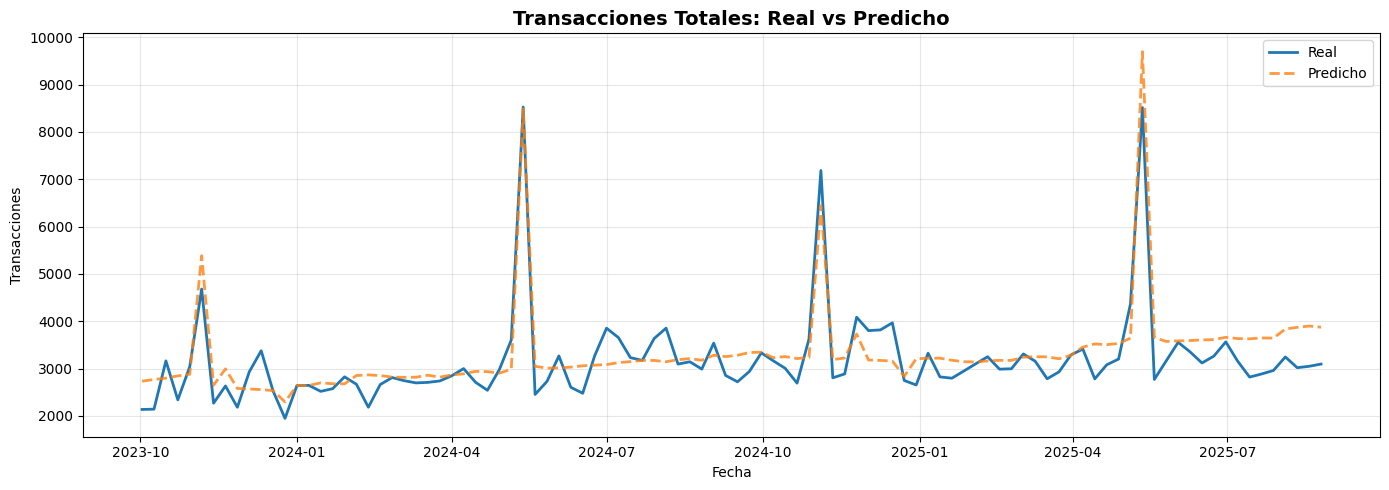

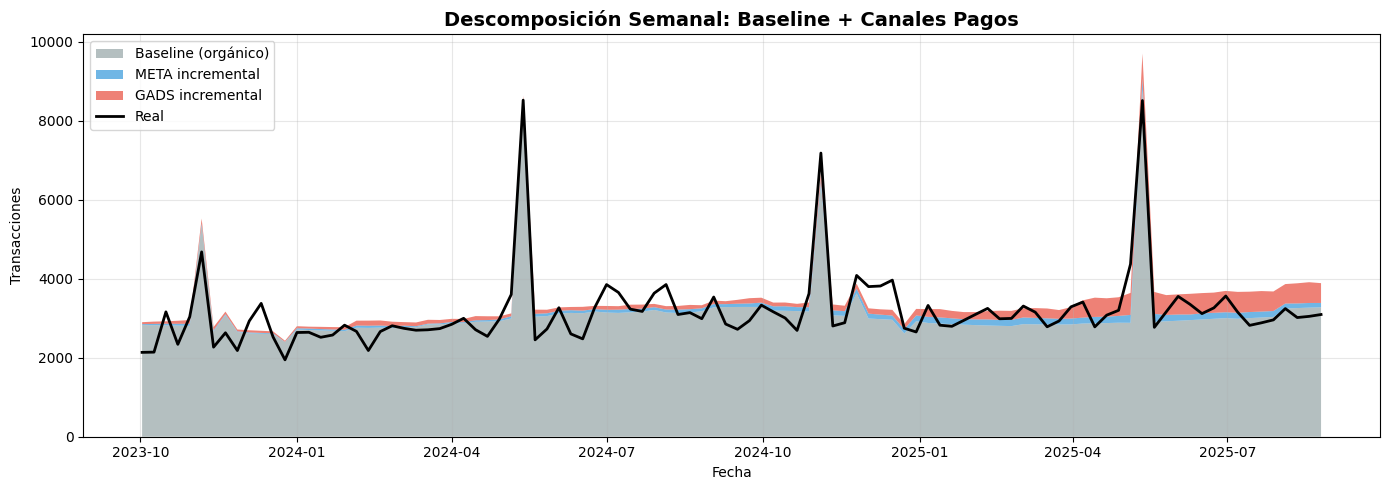

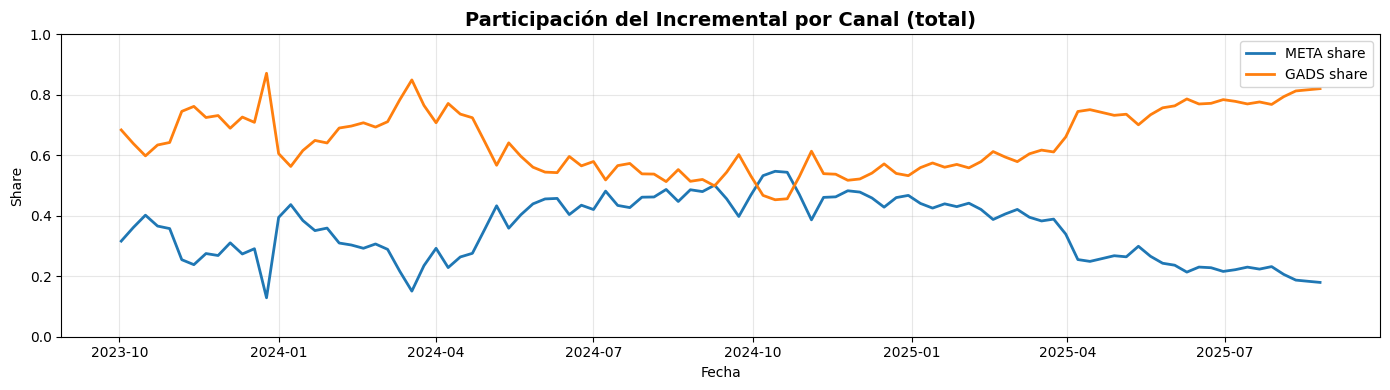

\n📊 SHARE PROMEDIO:
  META: 35.47%
  GADS: 64.53%


In [11]:
# 1) Real vs Predicho (total semanal)
tot = attrib_inc.groupby("Fecha")[["y_real", "y_hat"]].sum().sort_index()

plt.figure(figsize=(14, 5))
plt.plot(tot.index, tot["y_real"], label="Real", linewidth=2)
plt.plot(tot.index, tot["y_hat"], label="Predicho", linewidth=2, linestyle="--", alpha=0.8)
plt.title("Transacciones Totales: Real vs Predicho", fontsize=14, weight="bold")
plt.xlabel("Fecha")
plt.ylabel("Transacciones")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Descomposición por canal (stacked area)
tot_full = attrib_inc.groupby("Fecha")[["y_base", "META_incr", "GADS_incr", "y_real", "y_hat"]].sum().sort_index()

plt.figure(figsize=(14, 5))
plt.stackplot(tot_full.index, 
              tot_full["y_base"], 
              tot_full["META_incr"], 
              tot_full["GADS_incr"],
              labels=["Baseline (orgánico)", "META incremental", "GADS incremental"],
              alpha=0.7, colors=["#95a5a6", "#3498db", "#e74c3c"])
plt.plot(tot_full.index, tot_full["y_real"], label="Real", color="black", linewidth=2)
plt.title("Descomposición Semanal: Baseline + Canales Pagos", fontsize=14, weight="bold")
plt.xlabel("Fecha")
plt.ylabel("Transacciones")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Shares por canal en el tiempo
tot_full["share_META"] = tot_full["META_incr"] / (tot_full["META_incr"] + tot_full["GADS_incr"] + 1e-8)
tot_full["share_GADS"] = tot_full["GADS_incr"] / (tot_full["META_incr"] + tot_full["GADS_incr"] + 1e-8)

plt.figure(figsize=(14, 4))
plt.plot(tot_full.index, tot_full["share_META"], label="META share", linewidth=2)
plt.plot(tot_full.index, tot_full["share_GADS"], label="GADS share", linewidth=2)
plt.ylim(0, 1)
plt.title("Participación del Incremental por Canal (total)", fontsize=14, weight="bold")
plt.xlabel("Fecha")
plt.ylabel("Share")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\\n📊 SHARE PROMEDIO:")
print(f"  META: {tot_full['share_META'].mean():.2%}")
print(f"  GADS: {tot_full['share_GADS'].mean():.2%}")


## 9. Exportar Resultados

Guardamos los resultados para usar en el notebook de curvas de respuesta.


In [12]:
# Guardar atribución incremental
attrib_inc.to_csv("atribucion_incremental.csv", index=False)
print("✓ Guardado: 'atribucion_incremental.csv'")

# Guardar coeficientes
beta.to_csv("coeficientes_modelo.csv", header=True)
print("✓ Guardado: 'coeficientes_modelo.csv'")

# Guardar métricas
pd.DataFrame(metrics).T.to_csv("metricas_modelo.csv")
print("✓ Guardado: 'metricas_modelo.csv'")

# Guardar parámetros
params = {
    "TARGET": TARGET,
    "THETA_META": THETA_META,
    "ALPHA_META": ALPHA_META,
    "THETA_GADS": THETA_GADS,
    "ALPHA_GADS": ALPHA_GADS,
    "RIDGE_ALPHA": float(ridge.alpha_),
    "N_EMPRESAS": int(df_ok["empresa"].nunique()),
    "N_FILAS": int(len(attrib_inc)),
}
pd.Series(params).to_csv("parametros_modelo.csv", header=False)
print("✓ Guardado: 'parametros_modelo.csv'")


✓ Guardado: 'atribucion_incremental.csv'
✓ Guardado: 'coeficientes_modelo.csv'
✓ Guardado: 'metricas_modelo.csv'
✓ Guardado: 'parametros_modelo.csv'


## 10. Resumen Ejecutivo


In [14]:
print("="*80)
print("                RESUMEN: MODELO MMM")
print("="*80)

print(f"\\n🎯 CONFIGURACIÓN:")
print(f"  Target:           {TARGET}")
print(f"  Features:         {len(feat)} variables")
print(f"  Empresas:         {df_ok['empresa'].nunique()}")
print(f"  Observaciones:    {len(attrib_inc):,}")

print(f"\\n📊 RENDIMIENTO:")
for split, m in metrics.items():
    print(f"  {split.upper():6s}: R² = {m['R2']:.3f} | RMSE = {m['RMSE']:.1f}")

print(f"\\n💰 ATRIBUCIÓN INCREMENTAL (promedio semanal):")
print(f"  Baseline:   {attrib_inc['y_base'].mean():7.1f} transacciones")
print(f"  META:       {attrib_inc['META_incr'].mean():7.1f} transacciones ({attrib_inc['META_incr'].sum() / attrib_inc['incremental_total'].sum():.1%})")
print(f"  GADS:       {attrib_inc['GADS_incr'].mean():7.1f} transacciones ({attrib_inc['GADS_incr'].sum() / attrib_inc['incremental_total'].sum():.1%})")
print(f"  TOTAL:      {attrib_inc['y_real'].mean():7.1f} transacciones")

print(f"\\n🔑 COEFICIENTES DE MEDIOS:")
print(f"  β(META_resp) = {ridge.coef_[i_META]:+.4f} {'✅' if ridge.coef_[i_META] > 0 else '⚠️'}")
print(f"  β(GADS_resp) = {ridge.coef_[i_GADS]:+.4f} {'✅' if ridge.coef_[i_GADS] > 0 else '⚠️'}")

print(f"\\n✅ VARIABLES USADAS (SIN MULTICOLINEALIDAD):")
print("  • impressions_META (NO clicks_META)")
print("  • impressions_GADS (NO clicks_GADS)")
print("  • Transformaciones: Adstock (θ=0.30) + Hill (α=1.00)")

print(f"\\n🎯 PRÓXIMO PASO:")
print("  → Usar 'atribucion_incremental.csv' para ajustar curvas de respuesta Hill")
print("  → Las curvas reflejarán correctamente el efecto total de cada canal")
print("="*80)


                RESUMEN: MODELO MMM
\n🎯 CONFIGURACIÓN:
  Target:           transactions_GA
  Features:         8 variables
  Empresas:         22
  Observaciones:    2,058
\n📊 RENDIMIENTO:
  TRAIN : R² = 0.877 | RMSE = 103.3
  VALID : R² = 0.880 | RMSE = 102.2
  TEST  : R² = 0.900 | RMSE = 77.6
\n💰 ATRIBUCIÓN INCREMENTAL (promedio semanal):
  Baseline:     151.9 transacciones
  META:           4.6 transacciones (32.4%)
  GADS:           9.7 transacciones (67.6%)
  TOTAL:        154.2 transacciones
\n🔑 COEFICIENTES DE MEDIOS:
  β(META_resp) = +12.2667 ✅
  β(GADS_resp) = +17.3908 ✅
\n✅ VARIABLES USADAS (SIN MULTICOLINEALIDAD):
  • impressions_META (NO clicks_META)
  • impressions_GADS (NO clicks_GADS)
  • Transformaciones: Adstock (θ=0.30) + Hill (α=1.00)
\n🎯 PRÓXIMO PASO:
  → Usar 'atribucion_incremental.csv' para ajustar curvas de respuesta Hill
  → Las curvas reflejarán correctamente el efecto total de cada canal
